# Digital agro 

# Sensitivity analysis of models

# Seminar - 24.04.2020

<img src="http://drive.google.com/uc?export=view&id=1uijz-Bm9Mxwv8eI6CL8QsumiP7ISqnFo">

<img src="http://drive.google.com/uc?export=view&id=1dPvni3r4B3FqMFKugxtT8GfH1_W1jNNR">

### The scheme and main blocks of the plant growth model

<img src="http://drive.google.com/uc?export=view&id=1Pm5Zysv5PxYcTAQDuPe0LNz_zbE0msEW">


## git clone 

In [10]:
!git clone https://github.com/mishagrol/Seminar_Sobol.git

fatal: destination path 'Seminar_Sobol' already exists and is not an empty directory.


In [0]:
!cp -r ./Seminar_Sobol/* .

In [12]:
!ls

'01 Getting Started with PCSE.ipynb'   README.md
 batch_output.png		       readme.rst
 data				       S1_estimates.npy
 dataproviders.py		       sample_data
 default.profraw		       Seminar_24_04_2020_DA.png
 fishery.py			       Seminar_24_04.ipynb
 head_weather_csv.txt		       Seminar_Sobol
 HPC.jpg			       sensitivity_NPK.py
 img				       Sobol_SA.txt
 indexevolution.png		       Sobol_seq_24_04_2020_DA.png
 LICENSE			       soybean-000-2015.csv
 monica.png			       spring-barley-2012.csv
 moscow_full_weather.csv	       start_notebook.bat
 PCSE_SA.py			       ST_estimates.npy
 Pipeline.png			       sugar-beet-2011.csv
 py3_pcse.yml			       sugar-beet-2014.csv
 __pycache__			       sugar-beet-2017.csv
 quazi-random-sobol-etc.gif	       tail_weather_csv.txt
 Radial_All_Crops_final.eps	       weather_full.csv
 Radial_all_crops.png		       weather_generator.sh
'Radial Convergence Plots.ipynb'       WOFOS.jpg
 RadialPlot.py			       wur-logo.txt
 rankingevolution.png


# Running PCSE/WOFOST with custom input datф

This Jupyter notebook will show you how to read inputs from files for running PCSE/WOFOST.

thanks to **Allard de Wit**

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. `PCSE` and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;
  3. The `matplotlib` module for generating charts

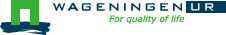



## Introduction

For running PCSE/WOFOST (and PCSE models in general) with your own data sources you need three different types of inputs:

 1. Model parameters that parameterize the different model components. These parameters usually consist of a set of crop parameters (or multiple sets in case of crop rotations), a set of soil parameters and a set of site parameters. The latter provide ancillary parameters that are specific for a location, for example the initial amount of moisture in the soil.
 2. Driving variables represented by weather data which can be derived from various sources.
 3. Agromanagement actions which specify the farm activities that will take place on the field that is simulated by PCSE.

For this example we will run a simulation for sugar beet in Wageningen (Netherlands) and we will read the input data step by step from several different sources instead of using the pre-configured start_wofost() script. For the example we will assume that data files are in the `data` directory within the directory where this notebook is located. This will be the case if you downloaded the notebooks from github.

## Importing the relevant modules


In [13]:
!pip install pcse

In [14]:
%matplotlib inline
import sys, os
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import numpy as np

data_dir = os.path.join(os.getcwd(), "data")
import pcse
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0] 
PCSE version: 5.4.2


## Reading model parameters
### Crop parameters

The crop parameters consist of parameter names and the corresponding parameter values that are needed to parameterize the components of the crop simulation model. These are crop-specific values regarding phenology, assimilation, respiration, biomass partitioning, etc. The parameter file for sugar beet is taken from the crop files in the WOFOST Control Centre.

As many crop models in Wageningen were written in FORTRAN, the crop parameters for many models in Wageningen are often provided in the CABO format that could be read with the TTUTIL FORTRAN library. This CABO format will be gradually phased out and PCSE will move to a new format based on YAML, see [here for an example](https://github.com/ajwdewit/WOFOST_crop_parameters/blob/master/wheat.yaml). However, PCSE tries to be backward compatible as much as possible and provides the `CABOFileReader` for reading parameter files in CABO format. The `CABOFileReader` returns a dictionary with the parameter name/value pairs:

In [0]:
from pcse.fileinput import CABOFileReader
cropfile = os.path.join(data_dir, 'crop', 'SUG0601.crop')
cropdata = CABOFileReader(cropfile)

In [16]:
# Number of parameters for our crop 
len(cropdata)

63

In [17]:
#cropdata
!ls ./data/crop

lintul3_springwheat.crop  MAG201.CAB  POT701.CAB  SUG0601.CAB  SUG0601.crop


### Soil parameters
The soildata dictionary provides the parameter name/value pairs related to the soil type and soil physical properties. The number of parameters is variable depending on the soil water balance type that is used for the simulation. For this example, we will use the water balance for freely draining soils and use the soil file for medium fine sand: `ec3.soil`. This file is also taken from the soil files in the [WOFOST Control Centre](http://www.wageningenur.nl/wofost).

In [0]:
soilfile = os.path.join(data_dir, 'soil', 'ec3.soil')
soildata = CABOFileReader(soilfile)

In [19]:
len(soildata)

16

In [0]:
#soildata

### Site parameters

The site parameters provide ancillary parameters that are not related to the crop or the soil. Examples are the initial conditions of the water balance such as the initial soil moisture content (WAV) and the initial and maximum surface storage (SSI, SSMAX). Also the atmospheric $CO_{2}$ 
concentration is a typical site parameter. For the moment, we can define these parameters directly on the Python commandline as a simple python dictionary. However, it is more convenient to use the `WOFOST71SiteDataProvider` that documents the site parameters and provides sensible defaults:

In [21]:
from pcse.util import WOFOST71SiteDataProvider
sitedata = WOFOST71SiteDataProvider(WAV=100, CO2=360)
print(sitedata)

{'IFUNRN': 0, 'NOTINF': 0, 'SSI': 0.0, 'SSMAX': 0.0, 'WAV': 100.0, 'SMLIM': 0.4, 'CO2': 360.0}


### Packaging all parameters
Finally, we need to pack the different sets of parameters into one variable using the `ParameterProvider`. This is needed because PCSE expects one variable that contains all parameter values. Using this approach has the additional advantage that parameter value can be easily overridden in case of running multiple simulations with slightly different parameter values:

In [0]:
from pcse.base import ParameterProvider
parameters = ParameterProvider(cropdata=cropdata, soildata=soildata, sitedata=sitedata)

## Agromanagement
The agromanagement inputs provide the start date of the agricultural campaign, the start_date/start_type of the crop simulation, the end_date/end_type of the crop simulation and the maximum duration of the crop simulation. The latter is included to avoid unrealistically long simulations for example as a results of a too high temperature sum requirement.

The agromanagement inputs are defined with a special syntax called [YAML](http://yaml.org/) which allows to easily create more complex structures which is needed for defining the agromanagement. The agromanagement file for sugar beet in Wageningen `sugarbeet_calendar.agro` can be read with the `YAMLAgroManagementReader`:

In [23]:
from pcse.fileinput import YAMLAgroManagementReader
#crop rotation for Moscow region
#agromanagement_file = os.path.join(data_dir, 'agro', 'sugarbeet_calendar_Moscow_short.agro')
agromanagement_file = os.path.join(data_dir, 'agro', 'sugarbeet_calendar.agro')
agromanagement = YAMLAgroManagementReader(agromanagement_file)
print(agromanagement)

!!python/object/new:pcse.fileinput.yaml_agro_loader.YAMLAgroManagementReader
listitems:
- 2006-01-01:
    CropCalendar:
      crop_end_date: 2006-10-20
      crop_end_type: harvest
      crop_name: sugar-beet
      crop_start_date: 2006-04-05
      crop_start_type: emergence
      max_duration: 300
      variety_name: sugar-beet-601
    StateEvents: null
    TimedEvents: null



We can create a crop rotation in the model


In [24]:
K_kg = 60
P_kg = 60
N_kg = 120
year_date=2019
yaml_agro = f"""
- {year_date}-06-01:
    CropCalendar:
        crop_name: 'sugar-beet'
        variety_name: 'sugar-beet-601'
        crop_start_date: {year_date}-06-02
        crop_start_type: emergence
        crop_end_date: {year_date}-10-15
        crop_end_type: harvest
        max_duration: 300
    TimedEvents:
    -   event_signal: apply_npk
        name:  Timed N/P/K application table
        comment: All fertilizer amounts in kg/ha
        events_table:
        - {year_date}-06-22: {{N_amount : {N_kg}, P_amount: {P_kg}, K_amount: {K_kg}}}
    StateEvents: null
"""
#agromanagement = yaml.safe_load(yaml_agro)
print(yaml_agro)


- 2019-06-01:
    CropCalendar:
        crop_name: 'sugar-beet'
        variety_name: 'sugar-beet-601'
        crop_start_date: 2019-06-02
        crop_start_type: emergence
        crop_end_date: 2019-10-15
        crop_end_type: harvest
        max_duration: 300
    TimedEvents:
    -   event_signal: apply_npk
        name:  Timed N/P/K application table
        comment: All fertilizer amounts in kg/ha
        events_table:
        - 2019-06-22: {N_amount : 120, P_amount: 60, K_amount: 60}
    StateEvents: null



## Daily weather observations
Daily weather variables are needed for running the simulation. There are several data providers in PCSE for reading weather data, see the section on [weather data providers](http://pcse.readthedocs.io/en/stable/reference_guide.html#weather-data-providers) to get an overview.

For this example we will use weather data from an excel file which provides daily weather data for Wageningen for the period 2004 to 2008. We will read the data from the file using the ExcelWeatherDataProvider:

### NASA Weather Data Provider from NASA [DataBase](https://power.larc.nasa.gov/)

In [0]:
#NASA Weather system
from pcse.db import NASAPowerWeatherDataProvider

In [26]:
#export weather to list
moscow_weather = NASAPowerWeatherDataProvider(55.45, 37.36)
print(moscow_weather)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER SRB/FLASHFlux/MERRA2/GEOS 5.12.4 (FP-IT) 0.5 x 0.5 Degree Daily Averaged Data
----Site characteristics----
Elevation:  181.1
Latitude:  55.450
Longitude: 37.360
Data available for 1983-07-01 - 2020-04-16
Number of missing days: 8



Weather loader for __NH__ example

In [27]:
from pcse.fileinput import ExcelWeatherDataProvider
weatherfile = os.path.join(data_dir, 'meteo', 'nl1.xlsx')
wdp = ExcelWeatherDataProvider(weatherfile)
print(wdp)

Weather data provided by: ExcelWeatherDataProvider
--------Description---------
Weather data for:
Country: Netherlands
Station: Wageningen, Location Haarweg
Description: Observed data from Station Haarweg in Wageningen
Source: Meteorology and Air Quality Group, Wageningen University
Contact: Peter Uithol
----Site characteristics----
Elevation:    7.0
Latitude:  51.970
Longitude:  5.670
Data available for 2004-01-02 - 2008-12-31
Number of missing days: 0



## Importing, initializing and running a PCSE model

Internally, PCSE uses a simulation engine to run a crop simulation. This engine takes a configuration file that specifies the components for the crop, the soil and the agromanagement that need to be used for the simulation. So any PCSE model can be started by importing the engine and initializing it with a given configuration file and the corresponding parameters, weather data and agromanagement.

However, as many users of PCSE only need a particular configuration (for example the WOFOST model for potential production), preconfigured Engines are provided in `pcse.models`. For the sugarbeet example we will import the WOFOST model for water-limited simulation under freely draining soil conditions:

In [0]:
from pcse.models import Wofost71_WLP_FD
#wofsim = Wofost71_WLP_FD(parameters, moscow_weather, agromanagement)

In [29]:
from pcse.models import Wofost71_WLP_FD
wofsim = Wofost71_WLP_FD(parameters, wdp, agromanagement)
wofsim.run_till_terminate()
df_results = pd.DataFrame(wofsim.get_output())
df_results = df_results.set_index("day")
df_results.tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2006-10-16,2.0,1.048787,21557.705173,14410.185356,3408.824045,3738.695772,2805.686837,0.052878,120.0,0.283340,34.000845
2006-10-17,2.0,1.055901,21628.846417,14474.212476,3412.381108,3742.252834,2807.138699,0.030516,120.0,0.282876,33.945161
2006-10-18,2.0,1.049414,21658.771700,14501.145230,3413.877372,3743.749098,2807.749419,0.030184,120.0,0.284605,34.152545
2006-10-19,2.0,1.052133,21685.964928,14525.619135,3415.237033,3745.108759,2808.304383,0.043053,120.0,0.284840,34.180768
2006-10-20,2.0,1.043584,21717.141971,14553.678474,3416.795885,3746.667611,2808.940650,0.039061,120.0,0.284271,34.112520


We can then run the simulation and retrieve the time series of daily simulation output using the get_output() method on the WOFOST object. Finally, we convert the simulation results to a pandas dataframe:

In [0]:
summary_output = wofsim.get_summary_output()

In [31]:
wofsim.get_summary_output()

[{'CTRAT': 29.87844231452199,
  'DOA': datetime.date(2006, 6, 15),
  'DOE': datetime.date(2006, 4, 5),
  'DOH': datetime.date(2006, 10, 20),
  'DOM': datetime.date(2006, 9, 17),
  'DOS': None,
  'DOV': None,
  'DVS': 2.0,
  'LAIMAX': 5.367243094787345,
  'RD': 120.0,
  'TAGP': 21717.14197118098,
  'TWLV': 3416.7958853006903,
  'TWRT': 2808.940649509448,
  'TWSO': 14553.678474455044,
  'TWST': 3746.6676114252446}]

In [32]:
msg = "Reached maturity at {DOM} with total biomass {TAGP} kg/ha "\
"and a yield of {TWSO} kg/ha."
print(msg.format(**summary_output[0]))

Reached maturity at 2006-09-17 with total biomass 21717.14197118098 kg/ha and a yield of 14553.678474455044 kg/ha.


# Sensitivity analysis

In [33]:
!pip install SALib

     |████████████████████████████████| 860kB 3.4MB/s 
  Created wheel for SALib: filename=SALib-1.3.11-py2.py3-none-any.whl size=729664 sha256=31127e559769320d04b8de314c945335f12c6529a8e15594dc56bedfa989bb56
  Stored in directory: /root/.cache/pip/wheels/62/ed/f9/a0b98754ffb2191b98324b96cbbeb1bd5d9598b39ab996b429
Successfully built SALib


In [0]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

__Docs [SALib](https://salib.readthedocs.io/en/latest/#)__

In this example, we will perform a Sobol’ sensitivity analysis of the _Ishigami_ function, shown below. The _Ishigami_ function is commonly used to test uncertainty and sensitivity analysis methods because it exhibits strong nonlinearity and nonmonotonicity.

$f(x)=\sin \left(x_{1}\right)+ \text{a}\, \operatorname{sin}^{2}\left(x_{2}\right)+ \text{b}\,  x_{3}^{4} \sin \left(x_{1}\right)$

In [0]:
problem = {
  'num_vars': 3,
  'names': ['x1', 'x2', 'x3'],
  'bounds': [[-np.pi, np.pi]]*3
}

In [36]:
# Generate samples
param_values = saltelli.sample(problem, 10, calc_second_order=True)
param_values.shape

(80, 3)

Here, `param_values` is a NumPy matrix. If we run `param_values.shape`, we see that the matrix is **8000 by 3**. The Saltelli sampler generated 8000 samples. The Saltelli sampler generates $N∗(2D+2)$ samples, where in this example $N$ is 1000 (the argument we supplied) and $D$ is 3 (the number of model inputs). The keyword argument `calc_second_order=False` will exclude second-order indices, resulting in a smaller sample matrix with $N∗(D+2)$ rows instead.


In [37]:
# Run model (example)
Y = Ishigami.evaluate(param_values)

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)
T_Si, first_Si, (idx, second_Si) = sobol.Si_to_pandas_dict(Si)

Parameter S1 S1_conf ST ST_conf
x1 -0.203434 0.600917 1.345837 1.837833
x2 0.838328 0.552777 0.716922 0.573149
x3 -0.592087 0.356414 0.459872 0.329910

Parameter_1 Parameter_2 S2 S2_conf
x1 x2 0.208665 1.084091
x1 x3 1.165212 0.855712
x2 x3 0.268558 0.730003


Consider the model output as
\begin{eqnarray*}
Y=f(X)=f\left(X_{1}, \ldots, X_{p}\right),
\end{eqnarray*}
where $f$ in our case part of agro-model simulator, $X$ are $p$ varied input parameters and $Y$ is the predicted output. Following the techniques by Sobol we represent the multi-variate random function $f$ using Hoeffding decomposition:
\begin{equation}
f(X_1,\dots,X_p) = f_0 + \sum_i^p f_i + \sum_i^p\sum_{j>i}^p f_{ij} + \dots + f_{1\dots p},
\end{equation}
where $f_0$ is a constant term, $f_i = f_i(X_i)$ denotes main effects, $f_{ij} = f_{ij}(X_i, X_j)$ and others describe higher-order interactions. These terms can be written as
\begin{equation*}
\begin{split}
f_0 &= E(Y),\\
f_i &= E_{X_{\sim i}}(Y | X_i) - E(Y),\\
f_{ij} &= E_{X_{\sim ij}}(Y | X_i, X_j) - f_i - f_j - f_0,\\
\dots
\end{split}
\end{equation*}
where $E$ is mathematical expectation and $X_{\sim i}$ denotes all parameters except $i^\text{th}$. Under the assumption that the input parameters are independent, total variance $V(Y)$ of the crop yield can be decomposed as follows:
\begin{equation*}
V(Y) = \sum_i^p V_i + \sum_i^p\sum_{j>i}^p V_{ij} + \dots + V_{12\dots p},
\end{equation*}
where partial variances are
\begin{equation*}
\begin{split}
V_i &= V[f_i(X_i)] = V_{X_i}\left[E_{X_{\sim i}}(Y | X_i)\right],\\
V_{ij} &= V[f_{ij}(X_i,X_j)] = V_{X_iX_j}\left[E_{X_{\sim ij}}(Y | X_i, X_j)\right] - V_i - V_j,\\
\dots
\end{split}
\end{equation*}

## Sobol index (first order, second order, total index)

This way, sensitivity indices (SI) can be introduced as 
\begin{equation}
\Large
S_i = \frac{V_i}{V(Y)},~S_{ij} = \frac{V_{ij}}{V(Y)},~\dots
\end{equation}
In order to incorporate all of the interactions for a particular parameter, one can compute the total effect index:
\begin{equation}
S_{T_i} = \frac{E_{X_{\sim i}}\left[V_{X_i}(Y|X_{\sim i})\right]}{V(Y)} = 1 - \frac{V_{X_{\sim i}}\left[E_{X_i}(Y | X_{\sim i})\right]}{V(Y)}
\end{equation}


From this assumption we can conclude:
\begin{equation}
\Large
0 \leq S_i \leq S_{T_i} \leq 1
\end{equation}

## Sobol’ Sequences versus Random numbers and regular grid


<img src="http://drive.google.com/uc?export=view&id=1ezjA8aa50P08EUybwdDyo8JKCP7lU7zw">

## Modern Quasi-Random Sequences

<img src="http://drive.google.com/uc?export=view&id=1kG5oaUMB56a31Hw_NQiRR4ZLs5DyeINI">



More -
* [Wiki](https://en.wikipedia.org/wiki/Sobol_sequence)
* [Habr](https://habr.com/ru/post/440892/)
* Feature selection [Skoltech ML 2020](https://github.com/adasegroup/ML2020_lectures/blob/master/lecture9/Lecture_9_Model_Feature_Selection_Sensitivity.pdf)

# Sensitivity analysis of WOFOST model 

<img src="http://drive.google.com/uc?export=view&id=1OPZ0xIFpc8Ku3wtt6XffKy2QKLashDWP">

## Install modules 

In [0]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
import pandas as pd

## Parameters

In [0]:
NPK = {
    'num_vars':3,
    'names':['N_kg', 'P_kg', 'K_kg'],
    'bounds':[[30., 60.],
              [60., 90.],
              [100., 130.]]
}

In [0]:
Soil_parameters = {
  'num_vars':5,
    'names':['SMV', 'SMFCF', 'SM0', 'CRAIRC', 'K0'],
    'bounds':[[0.7, 1.3],
              [0.1, 0.5],
              [0.2, 0.6],
             [0.04, 0.08],
             [22.5, 27.5]]}

## Generate input parameters

<img src="http://drive.google.com/uc?export=view&id=1A5v1WOrapL79dARWdXdcuHuVL8rEJLDi">


In [0]:
param_values = saltelli.sample(Soil_parameters, 10)

$n = N \times (D \times 2 +2)$

In [42]:
param_values.shape

(120, 5)

## Loop for yield prediction

In [0]:
from pcse.fileinput import YAMLAgroManagementReader
agromanagement_file = os.path.join(data_dir, 'agro', './sugarbeet_calendar.agro')
agromanagement = YAMLAgroManagementReader(agromanagement_file)
#print(agromanagement)
Soil_parameters = {
  'num_vars':5,
    'names':['SMV', 'SMFCF', 'SM0', 'CRAIRC', 'K0'],
    'bounds':[[0.7, 1.3],
              [0.1, 0.5],
              [0.2, 0.6],
             [0.04, 0.08],
             [22.5, 27.5]]}
param_values = saltelli.sample(Soil_parameters, N=10, calc_second_order=True)

Soil parameters in [PCSE model](https://pcse.readthedocs.io/en/stable/code.html?highlight=K0#pcse.soil.WaterbalanceFD) 

In [0]:
def sensitivity_soil(soil_parameters):
    SMV, SMFCF, SM0, CRAIRC, K0 = soil_parameters 
    soildata['SMV'] = SMV
    soildata['SMFCF'] = SMFCF
    soildata['SM0'] = SM0
    soildata['CRAIRC'] = CRAIRC
    soildata['K0'] = K0
    parameters = ParameterProvider(cropdata=cropdata, soildata=soildata, sitedata=sitedata)
    wofsim = Wofost71_WLP_FD(parameters, wdp, agromanagement)
    wofsim.run_till_terminate()
    #df_results = pd.DataFrame(wofsim.get_output())
    #df_results = df_results.set_index("day")
    #df_results.tail()
    summary_output = wofsim.get_summary_output()
    yield_list.append(summary_output[0]['TWSO'])

In [45]:
%%time
yield_list = []
param_values = saltelli.sample(Soil_parameters, 10, calc_second_order=True)
for st in range(len(param_values)):
    sensitivity_soil(param_values[st])
    print('.', end='')

........................................................................................................................CPU times: user 1min 14s, sys: 291 ms, total: 1min 15s
Wall time: 1min 15s


In [0]:
np_yield = np.array(yield_list)
Si = sobol.analyze(Soil_parameters, np_yield, print_to_console=False)

In [47]:
Si_dict = dict(Si) 
Si_df = pd.DataFrame()
Si_df = Si_df.append(pd.Series(Si_dict['S1']), ignore_index=True)
Si_df = Si_df.append(pd.Series(Si_dict['ST']), ignore_index=True)
Si_df = Si_df.append(pd.Series(Si_dict['S1_conf']), ignore_index=True)
Si_df = Si_df.append(pd.Series(Si_dict['ST_conf']), ignore_index=True)
Si_df = Si_df.T
Si_df.columns = ['Si', 'ST', 'Si_conf', 'ST_conf']
Si_df.rename(index={0:'SMV',1:'SMFCF', 2:'SM0', 3:'CRAIRC', 4:'K0'}, inplace=True)
Si_df

,Si,ST,Si_conf,ST_conf
SMV,0.000000,0.000000,0.000000,0.000000
SMFCF,-0.125075,0.433048,0.865365,0.831111
SM0,0.256621,0.377433,0.498367,0.507346
CRAIRC,0.000000,0.000000,0.000000,0.000000
K0,0.000000,0.000000,0.000000,0.000000


Is it ok?


\begin{equation}
\Large
0 \leq S_i \leq S_{T_i} \leq 1
\end{equation}

## Visualizing simulation results

Finally, we can generate some figures of WOFOST variables such as the development (DVS), total biomass (TAGP), leaf area index (LAI) and root-zone soil moisture (SM) using the MatPlotLib plotting package:

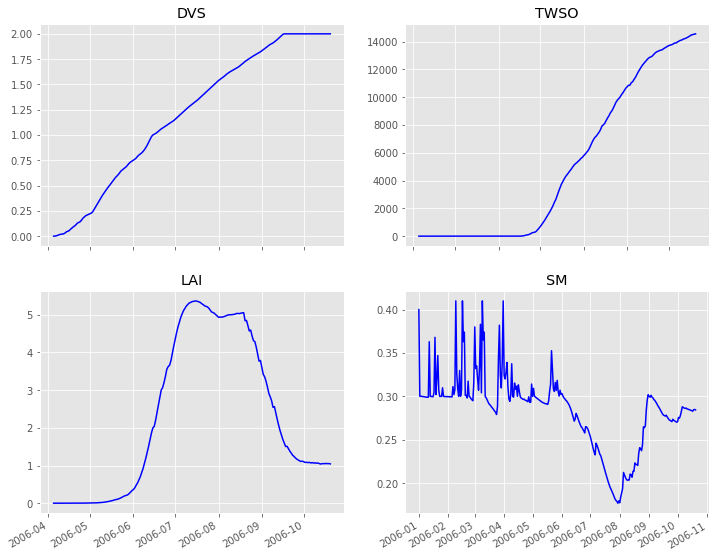

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for var, ax in zip(["DVS", "TWSO", "LAI", "SM"], axes.flatten()):
    ax.plot_date(df_results.index, df_results[var], 'b-')
    ax.set_title(var)
fig.autofmt_xdate()

# Visualization for sensitivity analysis

Plots by [Water programming group](https://waterprogramming.wordpress.com/2019/08/27/a-python-implementation-of-grouped-radial-convergence-plots-to-visualize-sobol-sensitivity-analysis-results/)

How to repeat: [Repo of SampleVIS](https://github.com/charlesrouge/SampleVis)

In [0]:
import numpy as np
from SALib.analyze import sobol
from SALib.sample import saltelli
from fishery import fish_game
import matplotlib.pyplot as plt
import itertools
import math

### Why number of samples is important?

n= 50
n= 100
n= 150
n= 200
n= 250
n= 300
n= 350
n= 400
n= 450


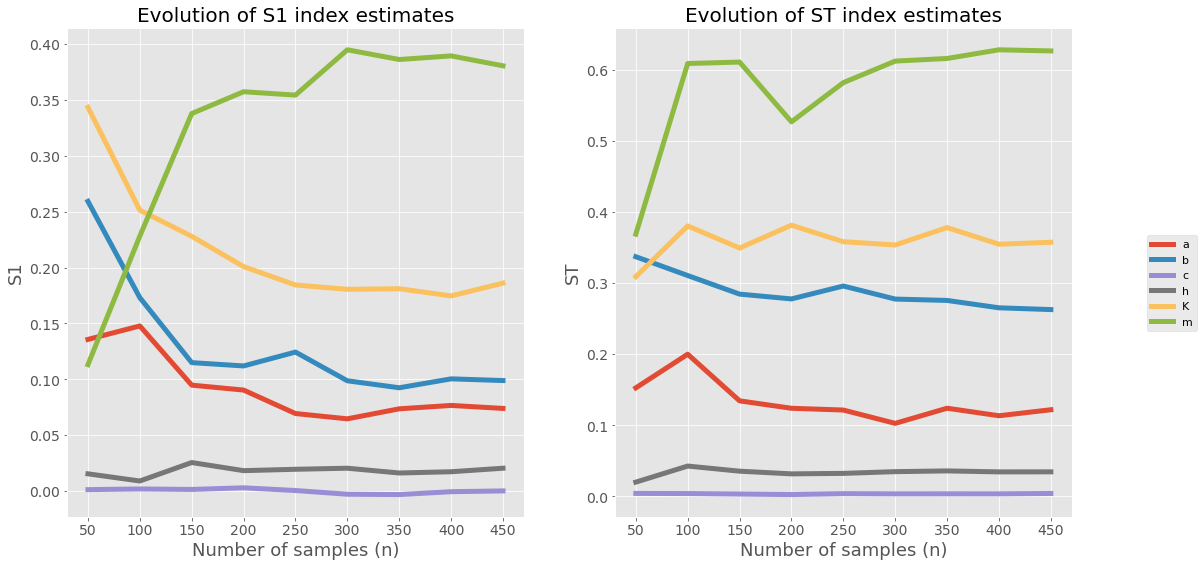

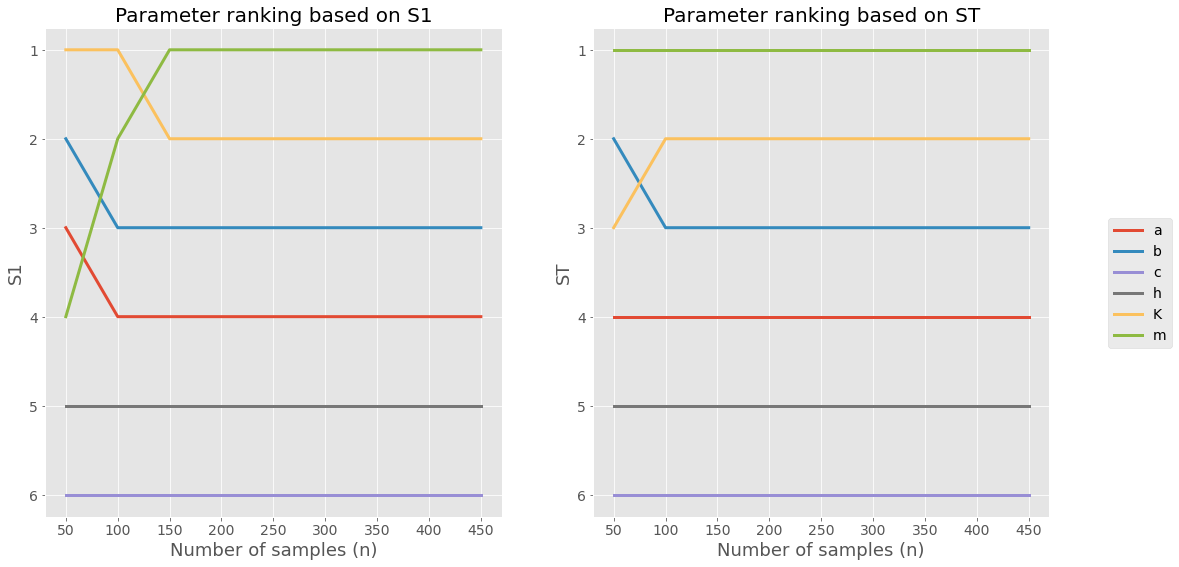

In [50]:
# Set up dictionary with system parameters
problem = {
  'num_vars': 6,
  'names': ['a', 'b', 'c','h',
            'K','m'],
  'bounds': [[ 0.002, 2],
             [0.005, 1],
             [0.2, 1],
             [0.001, 1],
             [100, 5000],
             [0.1, 1.5]]
}

# Array with n's to use
nsamples = np.arange(50, 500, 50)

# Arrays to store the index estimates
S1_estimates = np.zeros([problem['num_vars'],len(nsamples)])
ST_estimates = np.zeros([problem['num_vars'],len(nsamples)])

# Loop through all n values, create sample, evaluate model and estimate S1 & ST
for i in range(len(nsamples)):
    print('n= '+ str(nsamples[i]))
    # Generate samples
    sampleset = saltelli.sample(problem, nsamples[i],calc_second_order=False)
    # Run model for all samples
    output = [fish_game(*sampleset[j,:]) for j in range(len(sampleset))]
    # Perform analysis
    results = sobol.analyze(problem, np.asarray(output), calc_second_order=False,print_to_console=False)
    # Store estimates
    ST_estimates[:,i]=results['ST']
    S1_estimates[:,i]=results['S1']

np.save('ST_estimates.npy', ST_estimates)
np.save('S1_estimates.npy', S1_estimates)

S1_estimates = np.load('S1_estimates.npy')
ST_estimates = np.load('ST_estimates.npy')

# Generate figure showing evolution of indices
fig =  plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(1,2,1)
handles = []
for j in range(problem['num_vars']):
    handles += ax1.plot(nsamples, S1_estimates[j,:], linewidth=5)
ax1.set_title('Evolution of S1 index estimates', fontsize=20)
ax1.set_ylabel('S1', fontsize=18)
ax1.set_xlabel('Number of samples (n)', fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2 = fig.add_subplot(1,2,2)
for j in range(problem['num_vars']):
    ax2.plot(nsamples, ST_estimates[j,:], linewidth=5)
ax2.set_title('Evolution of ST index estimates', fontsize=20)
ax2.set_ylabel('ST', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel('Number of samples (n)', fontsize=18)
fig.legend(handles, problem['names'], loc = 'right', fontsize=11)
plt.show()
#plt.savefig('indexevolution.png')

# Calculate parameter rankings
S1_ranks = np.zeros_like(S1_estimates)
ST_ranks = np.zeros_like(ST_estimates)
for i in range(len(nsamples)):
    orderS1 = np.argsort(S1_estimates[:,i])
    orderST = np.argsort(ST_estimates[:,i])
    S1_ranks[:,i] = orderS1.argsort()
    ST_ranks[:,i] = orderST.argsort()
    
# Generate figure showing evolution of ranks
fig =  plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(1,2,1)
handles = []
for j in range(problem['num_vars']):
    handles += ax1.plot(nsamples, S1_ranks[j,:], linewidth=3)
ax1.set_title('Parameter ranking based on S1', fontsize=20)
ax1.set_ylabel('S1', fontsize=18)
ax1.set_xlabel('Number of samples (n)', fontsize=18)
ax1.set_yticklabels(np.arange(problem['num_vars']+1, 0, -1))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2 = fig.add_subplot(1,2,2)
for j in range(problem['num_vars']):
    ax2.plot(nsamples, ST_ranks[j,:], linewidth=3)
ax2.set_title('Parameter ranking based on ST', fontsize=20)
ax2.set_ylabel('ST', fontsize=18)
ax2.set_yticklabels(np.arange(problem['num_vars']+1, 0, -1))
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel('Number of samples (n)', fontsize=18)
fig.legend(handles, problem['names'], loc = 'right', fontsize=14)
#plt.show()
#plt.savefig('rankingevolution.png')

## Radial plot for SA

In [51]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy import genfromtxt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
sns.set_style('whitegrid', {'axes_linewidth': 0, 'axes.edgecolor': 'white'})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Plot function

In [0]:
def is_significant(value, confidence_interval, threshold="conf"):
    if threshold == "conf":
        return value - abs(confidence_interval) > 0
    else:
        return value - abs(float(threshold)) > 0
 
def grouped_radial(SAresults, parameters, radSc=2.0, scaling=1, widthSc=0.5, STthick=1, varNameMult=1.3, colors=None, groups=None, gpNameMult=1.5, threshold="conf"):
    # Derived from https://github.com/calvinwhealton/SensitivityAnalysisPlots
    fig, ax = plt.subplots(1, 1)
    color_map = {}
     
    # initialize parameters and colors
    if groups is None:
         
        if colors is None:
            colors = ["k"]
         
        for i, parameter in enumerate(parameters):
            color_map[parameter] = colors[i % len(colors)]
    else:        
        if colors is None:
            colors = sns.color_palette("deep", max(3, len(groups)))
         
        for i, key in enumerate(groups.keys()):
            #parameters.extend(groups[key])
             
            for parameter in groups[key]:
                color_map[parameter] = colors[i % len(colors)]
     
    n = len(parameters)
    angles = radSc*math.pi*np.arange(0, n)/n
    x = radSc*np.cos(angles)
    y = radSc*np.sin(angles)
     
    # plot second-order indices
    for i, j in itertools.combinations(range(n), 2):
        #key1 = parameters[i]
        #key2 = parameters[j]
         
        if is_significant(SAresults["S2"][i][j], SAresults["S2_conf"][i][j], threshold):
            angle = math.atan((y[j]-y[i])/(x[j]-x[i]))
                 
            if y[j]-y[i] < 0:
                angle += math.pi
                 
            line_hw = scaling*(max(0, SAresults["S2"][i][j])**widthSc)/2
                 
            coords = np.empty((4, 2))
            coords[0, 0] = x[i] - line_hw*math.sin(angle)
            coords[1, 0] = x[i] + line_hw*math.sin(angle)
            coords[2, 0] = x[j] + line_hw*math.sin(angle)
            coords[3, 0] = x[j] - line_hw*math.sin(angle)
            coords[0, 1] = y[i] + line_hw*math.cos(angle)
            coords[1, 1] = y[i] - line_hw*math.cos(angle)
            coords[2, 1] = y[j] - line_hw*math.cos(angle)
            coords[3, 1] = y[j] + line_hw*math.cos(angle)
 
            ax.add_artist(plt.Polygon(coords, color="0.75"))
         
    # plot total order indices
    for i, key in enumerate(parameters):
        if is_significant(SAresults["ST"][i], SAresults["ST_conf"][i], threshold):
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["ST"][i]**widthSc)/2, color='w'))
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["ST"][i]**widthSc)/2, lw=STthick, color='0.4', fill=False))
     
    # plot first-order indices
    for i, key in enumerate(parameters):
        if is_significant(SAresults["S1"][i], SAresults["S1_conf"][i], threshold):
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["S1"][i]**widthSc)/2, color='0.4'))
            
    # add labels
    for i, key in enumerate(parameters):                
        ax.text(varNameMult*x[i], varNameMult*y[i], key, ha='center', va='center',
                rotation=angles[i]*360/(2*math.pi) - 90,
                color=color_map[key])
         
    if groups is not None:
        for i, group in enumerate(groups.keys()):
            print(group)
            group_angle = np.mean([angles[j] for j in range(n) if parameters[j] in groups[group]])
             
            ax.text(gpNameMult*radSc*math.cos(group_angle), gpNameMult*radSc*math.sin(group_angle), group, ha='center', va='center',
                rotation=group_angle*360/(2*math.pi) - 90,
                color=colors[i % len(colors)])
             
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.
    plt.axis('equal')
    plt.axis([-2*radSc, 2*radSc, -2*radSc, 2*radSc])
    #plt.show()
 
     
    return fig

## Range of soil parameters

In [0]:
problem = {
    'num_vars':6,
    'names':['SOC', 'Sand', 'Clay', 'pH', 'CN', 'BD'],
    'bounds':[[2.58, 6.20],
              [0.01, 0.30],
              [0.01, 0.30],
              [4.6, 6.9],
              [10.9, 12.4],
              [900, 1350]]
}

In [0]:
#names for csv files
list_of_csv=['soybean-000-2015.csv', 'sugar-beet-2011.csv', 'sugar-beet-2017.csv',
'spring-barley-2012.csv', 'sugar-beet-2014.csv']
list_of_names=['soybean-000-2015', 'sugar-beat-2011', 'sugar-beat-2017',
'spring-barley-2012', 'sugar-beat-2014']
list_of_totals=['total_SI_'+x for x in list_of_names]
list_of_first=['fisrt_SI_'+x for x in list_of_names]
list_of_second=['second_SI_'+x for x in list_of_names]
list_of_SI=['SI_'+x for x in list_of_names]

In [55]:
for j, i in enumerate(list_of_csv):
        all_data_csv = genfromtxt('./'+str(i), delimiter=',')
        output = all_data_csv[:,2]
        print(i)
        list_of_SI[j] = sobol.analyze(problem, output, calc_second_order=True, conf_level=0.95, print_to_console=False)

soybean-000-2015.csv
sugar-beet-2011.csv
sugar-beet-2017.csv
spring-barley-2012.csv
sugar-beet-2014.csv


Soil physics
Soil chemistry


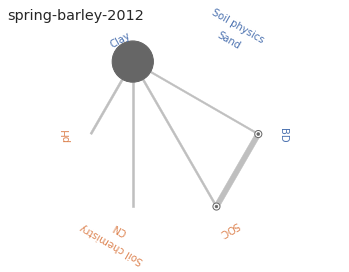

In [56]:
groups={"Soil physics" : ["Sand", "Clay", "BD"],
        "Soil chemistry" : ["pH", "SOC", "CN"]}
 
fig = grouped_radial(list_of_SI[1], ['BD', 'Sand', 'Clay', 'pH', 'CN', 'SOC'], groups=groups, threshold=0.001)
red_patch = mpatches.Patch(color='red', label='The red data')
plt.title(list_of_names[3], loc='left')

plt.show()

<img src="http://drive.google.com/uc?export=view&id=10AEhkAB_h8JeDp2YfqSgjBj1mONp2o3p">


## Homework

Usefull

__SA and UQ__


1) [Rhodium project](https://github.com/Project-Platypus/Rhodium.git)


2) [SALib](https://github.com/SALib/SALib)

__Model__

3) [PCSE](https://pcse.readthedocs.io/en/stable/index.html)

4) How to install PCSE at local machine
    `conda env create -f` [py3_pcse.yml](https://github.com/mishagrol/Seminar_Sobol/blob/master/py3_pcse.yml)

### bonus

__Morris method__


Generate a sample using the Method of Morris

Three variants of Morris' sampling for elementary effects is supported:

- Vanilla Morris
- Optimised trajectories when ``optimal_trajectories=True`` (using
    Campolongo's enhancements from 2007 and optionally Ruano's enhancement
    from 2012; ``local_optimization=True``)
- Groups with optimised trajectories when ``optimal_trajectories=True`` and
    the problem definition specifies groups (note that ``local_optimization``
    must be ``False``)

At present, optimised trajectories is implemented using either a brute-force
approach, which can be very slow, especially if you require more than four
trajectories, or a local method based which is much faster. Both methods now
implement working with groups of factors.

Note that the number of factors makes little difference,
but the ratio between number of optimal trajectories and the sample size
results in an exponentially increasing number of scores that must be
computed to find the optimal combination of trajectories.  We suggest going
no higher than 4 from a pool of 100 samples with the brute force approach.
With local_optimization = True (which is default),
it is possible to go higher than the previously suggested 4 from 100.



Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
x1                                  2.599      0.034           0.048      2.727
x2                                  1.494      0.040           0.050      1.683
x3                                  0.594     -0.033           0.019      0.691
x4                                  0.340      0.020           0.013      0.398
x5                                  0.034      0.002           0.001      0.040
x6                                  0.034      0.000           0.001      0.040
x7                                  0.034      0.000           0.001      0.040
x8                                  0.034      0.001           0.001      0.040


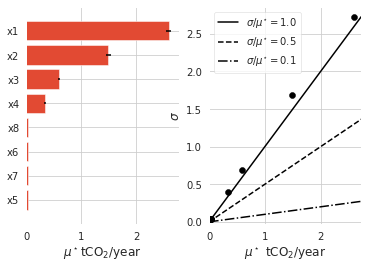

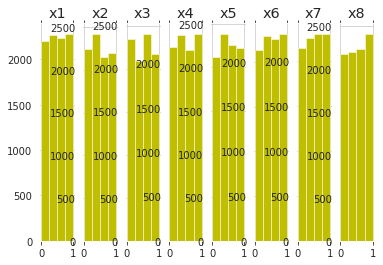

In [57]:
import sys

from SALib.analyze import morris
from SALib.sample.morris import sample
from SALib.test_functions import Sobol_G
from SALib.util import read_param_file
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, \
    sample_histograms
import matplotlib.pyplot as plt

#sys.path.append('../..')

# Read the parameter range file and generate samples
#problem = read_param_file('/Users/mikhailgasanov/Documents/GIT/SALib/src/SALib/test_functions/params/Sobol_G.txt')
# or define manually without a parameter file:
problem = {
 'num_vars': 8,
 'names': ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'],
 'groups': None,
 'bounds': [[0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0],
            [0.0, 1.0]]
}
# Files with a 4th column for "group name" will be detected automatically, e.g.
# param_file = '../../src/SALib/test_functions/params/Ishigami_groups.txt'

# Generate samples
param_values = sample(problem, N=1000, num_levels=4,
                      optimal_trajectories=None)

# To use optimized trajectories (brute force method),
# give an integer value for optimal_trajectories

# Run the "model" -- this will happen offline for external models
Y = Sobol_G.evaluate(param_values)

# Perform the sensitivity analysis using the model output
# Specify which column of the output file to analyze (zero-indexed)
Si = morris.analyze(problem, param_values, Y, conf_level=0.95,
                    print_to_console=True,
                    num_levels=4, num_resamples=100)
# Returns a dictionary with keys 'mu', 'mu_star', 'sigma', and 'mu_star_conf'
# e.g. Si['mu_star'] contains the mu* value for each parameter, in the
# same order as the parameter file

fig, (ax1, ax2) = plt.subplots(1, 2)
horizontal_bar_plot(ax1, Si, {}, sortby='mu_star', unit=r"tCO$_2$/year")
covariance_plot(ax2, Si, {}, unit=r"tCO$_2$/year")

fig2 = plt.figure()
sample_histograms(fig2, param_values, problem, {'color': 'y'})
plt.show()